In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import npm_nnf.utils.utils_kernels as KT 
import npm_nnf.density_estimation.utils_density as utils
import npm_nnf.density_estimation.utils_data_generator as generators

In [2]:
#path to saved tensors
pt_path = "ExperimentsD/tensors/"
fig_path = "ExperimentsD/figures/"
csv_pat = "ExperimentsD/tables/"

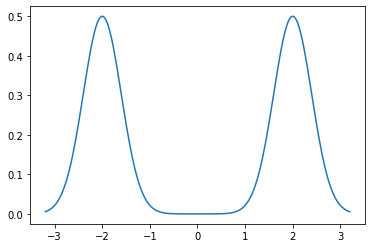

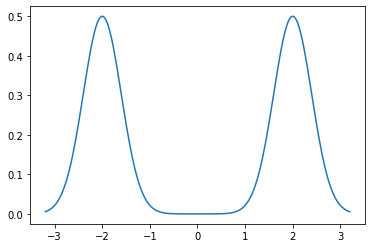

In [3]:
# Number of data points we will be using and basic parameters of the model



d = 10
#def gen(n = ndata):
#    ds,_ = generators.generateGaussianD(torch.zeros(d),1/np.sqrt(d),n,d)
#    return ds

r_data = 2
sigma_data = np.sqrt(1/(2*np.pi))
def gen(ndata):
    ds,_ = generators.generate2GaussianD(r_data,sigma_data,ndata,d)
    return ds

_,density_data=generators.generate2GaussianD(r_data,sigma_data,1,d)


def gentest(ntest,ctest,radtest,frac = 0.5):
    ds = torch.zeros((ntest,d))
    ntestrand = int(frac*ntest)
    ntestnear = ntest - ntestrand
    ds[:ntestrand,:] = ctest + radtest*(2*torch.rand(ntestrand,d) - 1)
    ds[ntestrand:,:],_ = generators.generate2GaussianD(r_data,sigma_data,ntestnear,d)
    return ds


base = 'gaussian'
mu_base,eta_base = torch.zeros((d,)),5

ndata = 1000
data_set = gen(ndata)
data_path = pt_path + 'xdataExperiments.pt'
torch.save(data_set,data_path)

def data_split(data_set,r=0.5):
    n = data_set.size(0)
    l = np.array(range(n))
    np.random.shuffle(l)
    data_set = data_set[l,:]
    del l
    ntr = int(np.ceil(n*r))
    nts = n - ntr
    data_set_train = data_set[:ntr,:]
    data_set_test = data_set[ntr:,:]
    return data_set_train,data_set_test

    

def loglikelihood(px,eps = 0,ntest=ndata,data_set_test = None):
    #Here eps is the moreau smoothing parameter
    if isinstance(data_set_test ,type(None)):
        xtest = gen(ntest)
    else:
        xtest = data_set_test
        ntest = xtest.size(0)
    p = px(xtest)
    if eps == 0:
        if (p<=0).sum() > 0:
            return torch.tensor(np.inf)
        else:
            return -(torch.log(p)).mean()
    else:
        LL = utils.loglossNW(eps/ntest)
        res = LL.Leps(p)/ntest
    return res

# Linear model

In [109]:
def makepx(data_set,la,sigma = 1,Niter = None):
    lmodel = utils.LMK(sigma,data_set,kernel = 'gaussian',centered = False,c = 0,base = base,mu_base = mu_base,eta_base = eta_base,useGPU = False,nmax_gpu = None,target_norm = 1)
    regmodel = utils.Sreg(la)
    dModel = utils.densityModel(regmodel,lmodel)
    if isinstance(Niter,type(None)):
        Niter = 40
    freq = Niter//5
    cb,cobj = dModel.cbcboj_pd(freq,plot = False)
    al = dModel.prox_method(Niter,cb = cb,cobj = cobj)
    def pxx(x):
        return dModel.px_dual(al,x)
    return pxx

## Finding the best $\lambda$ 

---iteration: 1---
---iteration: 87---
---iteration: 173---
---iteration: 259---
---iteration: 345---
lambda = 1e-06,sigma = 0.4
integral = tensor([[1.0000]])
ll = 8.649231678163744
---iteration: 1---
---iteration: 87---
---iteration: 173---
---iteration: 259---
---iteration: 345---
lambda = 1e-06,sigma = 0.5
integral = tensor([[1.0000]])
ll = 9.288312781204628
---iteration: 1---
---iteration: 87---
---iteration: 173---
---iteration: 259---
---iteration: 345---
lambda = 1e-06,sigma = 0.6
integral = tensor([[1.0000]])
ll = 10.086960618309309
---iteration: 1---
---iteration: 147---
---iteration: 293---
---iteration: 439---
---iteration: 585---
lambda = 1e-10,sigma = 0.4
integral = tensor([[1.0000]])
ll = 8.624384726914156
---iteration: 1---
---iteration: 147---
---iteration: 293---
---iteration: 439---
---iteration: 585---
lambda = 1e-10,sigma = 0.5
integral = tensor([[1.0000]])
ll = 9.213140768273215
---iteration: 1---
---iteration: 147---
---iteration: 293---
---iteration: 439---
---it

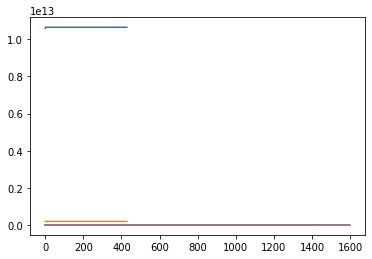

In [35]:
la_list = [1e-6,1e-10,1e-14,1e-17,1e-20,1e-23]
sigma_l = [0.4,0.5,0.6]
param_list = []
for la in la_list:
    for sigma in sigma_l:
        param_list.append([la,sigma])
NN = len(param_list)
res = torch.zeros((4,NN))
res[2:,:] = torch.tensor(param_list).T

r = 0.7
K = 1
res_list = []
data_set = torch.load(data_path)
for i in range(NN):
    for k in range(K):
        data_set_train,data_set_test = data_split(data_set,r=r)
        la,sigma = res[2,i],res[3,i]
        px = makepx(data_set_train,la,sigma = sigma,Niter = 40 + 30*int( -np.log(la)))
        print('lambda = {},sigma = {}'.format(la,sigma))
        ll = loglikelihood(px,data_set_test=data_set_test)
        #ll = squareloss(px,data_set_test = data_set_test,ntest = 0,ntestbis = 3000)
        print("ll = {}".format(ll))
        res[0,i] += ll
        res[1,i] += ll**2
    res[0,i]/= K
    res[1,i] /= K
    res[1,i] -= res[0,i]**2




In [39]:
torch.save(res,pt_path + 'lambda_choice_linear0.pt')

la
tensor([1.0000e-20, 1.0000e-17, 1.0000e-10, 1.0000e-06, 1.0000e-14, 1.0000e-17,
        1.0000e-17, 1.0000e-10, 1.0000e-14, 1.0000e-06, 1.0000e-10, 1.0000e-14,
        1.0000e-06, 1.0000e-20, 1.0000e-20, 1.0000e-23, 1.0000e-23, 1.0000e-23])
sigma
tensor([0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.5000, 0.6000, 0.5000, 0.5000,
        0.5000, 0.6000, 0.6000, 0.6000, 0.5000, 0.6000, 0.4000, 0.5000, 0.6000])
result
tensor([ 8.3670,  8.5939,  8.6244,  8.6492,  8.7055,  9.0786,  9.1148,  9.2131,
         9.2316,  9.2883, 10.0375, 10.0696, 10.0870,     inf,     inf,     inf,
            inf,     inf])
ecart type
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., nan, nan, nan, nan, nan])


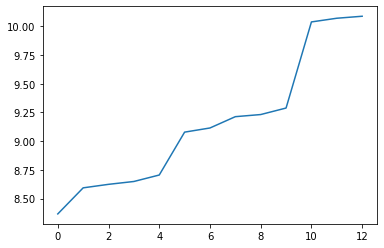

In [40]:
res_l = torch.load(pt_path +'lambda_choice_linear0.pt')
n = res_l.size(1)
_,i = torch.sort(res_l[0,:])
res_l = res_l[:,i]


print("la")
print(res_l[2,:])
print("sigma")
print(res_l[3,:])

print("result")
print(res_l[0,:])
print("ecart type")
print(torch.sqrt(res_l[1,:]))


plt.figure()
plt.plot(list(range(n)),res_l[0,:])
#plt.xlim(30,40)
plt.show()



## Performing the test 

---iteration: 1---
---iteration: 351---
---iteration: 701---
---iteration: 1051---
---iteration: 1401---


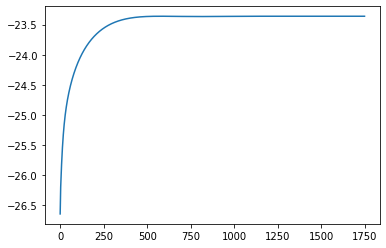

In [110]:
data_set = torch.load(data_path)
ndata = data_set.size(0)
#data_set = data_set.view(ndata,1)
la = 1e-25
px = makepx(data_set,la,sigma = 0.4,Niter = 40 + 30*int( -np.log(la)))

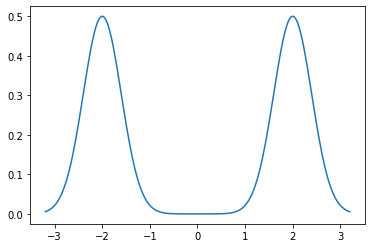

integral = tensor([[0.9990]])
integral = tensor([[0.9990]])
tensor(82)
tensor(2.1766e+09)
integral = tensor([[0.9990]])


In [116]:
#xtest = torch.linspace(-5,5,3000)
c,rad,ntest = 0,4,1000
xtest2 = gentest(ntest,c,rad)
xtest = torch.zeros((ntest//2,d))
xtest[:,0] = c + rad*(2*torch.rand(ntest//2) - 1)
ytest = px(xtest)
ytest2 = px(xtest2)
print((ytest < 0).sum())
print(ytest.sum()*(2*rad)**d/ntest)
ydata_set = px(data_set)



torch.save(xtest,pt_path+'xtest_linear1.pt')
torch.save(ytest,pt_path+'ytest_linear1.pt')
torch.save(ydata_set,pt_path+'ydata_linear1.pt')
torch.save(xtest2,pt_path+'xtest2_linear1.pt')
torch.save(ytest2,pt_path+'ytest2_linear1.pt')
#torch.save(xtest,pt_path+'xtest_linear0.pt')
#torch.save(ytest,pt_path+'ytest_linear0.pt')
#torch.save(ydata_set,pt_path+'ydata_linear0.pt')



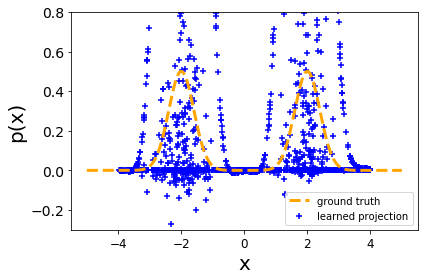

In [152]:
xtest = torch.load(pt_path+'xtest_linear1.pt')
ytest = torch.load(pt_path+'ytest_linear1.pt')
xdata = torch.load(pt_path+'xdataExperiments.pt')
ydata_set = torch.load(pt_path+'ydata_linear1.pt')
xtest2 = torch.load(pt_path+'xtest2_linear1.pt')
ytest2 = torch.load(pt_path+'ytest2_linear1.pt')


xhaha = torch.linspace(-rad,rad,200)
yhaha = 0.5*(torch.exp(-(xhaha-r_data)**2/(2*sigma_data**2)) +torch.exp(-(xhaha+r_data)**2/(2*sigma_data**2)) )




#xtest = torch.load(pt_path+'xtest_linear0.pt')
#ytest = torch.load(pt_path+'ytest_linear0.pt')
#xdata = torch.load(pt_path+'xdataExperiments.pt')
#ydata_set = torch.load(pt_path+'ydata_linear0.pt')


#ytestref = density_fun(xtest)



fig = plt.figure()
plt.scatter(xtest[:,0],ytest[:],lw = 1.5,label='learned projection',zorder = -1,marker = '+',color = 'b')
plt.scatter(xtest2[:,0],ytest2[:],lw = 1.5,zorder = -1,marker = '+',color = 'b')
plt.plot(xhaha,yhaha,lw = 3,linestyle = 'dashed',label = 'ground truth',color = 'orange')
#plt.plot(xtest,ytestref,linestyle = 'dashed',lw = 3,label = 'ground truth')
#plt.scatter(xdata,ydata_set,marker = '+',color = 'r',lw = 2,label = 'training points',zorder = 1)
plt.legend()
plt.xlabel("x",fontsize = 20)
plt.ylabel("p(x)",fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=12)
plt.ylim(-0.3,0.8)
plt.tight_layout()
fig.savefig('linearPlot0density.pdf' , format='pdf', dpi=100)
plt.show()

# Our model

In [118]:
def makepx(data_set,la,sigma = 1,Niter = 40):
    lmodel =  utils.QKM(sigma,data_set,kernel = 'gaussian',centered = False,c = 0,base = base,mu_base = mu_base,eta_base = eta_base,target_norm = np.sqrt(la*0.01))
    regmodel = utils.ENreg(la,la*0.01)
    dModel = utils.densityModel(regmodel,lmodel)
    freq = Niter // 5
    #cb,cobj = dModel.cbcboj_pd(freq,plot = False)
    al = dModel.prox_method(Niter)
    def pxx(x):
        return dModel.px_dual(al,x)
    return pxx


lambda = 1e-10,sigma = 0.4
integral = 1.0000004016760817
ll = 13.0816317972834
lambda = 1e-10,sigma = 0.5
integral = 1.0024284781068846
ll = 8.827560854458111
lambda = 1e-10,sigma = 0.6
integral = 0.999688924434802
ll = 8.777935032645463
lambda = 1e-10,sigma = 0.7
integral = 1.0065347677736654
ll = 9.258378929312686
lambda = 1e-10,sigma = 1.0
integral = 0.9996411396662739
ll = 11.19983773543058


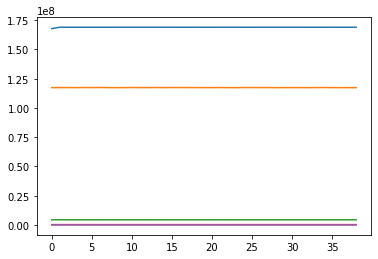

In [7]:
la_list = [1e-10]
sigma_l = [0.4,0.5,0.6,0.7,1]
param_list = []
for la in la_list:
    for sigma in sigma_l:
        param_list.append([la,sigma])
NN = len(param_list)
res = torch.zeros((4,NN))
res[2:,:] = torch.tensor(param_list).T

r = 0.7
K = 1
res_list = []
data_set = torch.load(data_path)
for i in range(NN):
    for k in range(K):
        data_set_train,data_set_test = data_split(data_set,r=r)
        la,sigma = res[2,i],res[3,i]
        px = makepx(data_set_train,la,sigma = sigma)
        print('lambda = {},sigma = {}'.format(la,sigma))
        ll = loglikelihood(px,data_set_test=data_set_test)
        #ll = squareloss(px,data_set_test = data_set_test,ntest = 0,ntestbis = 3000)
        print("ll = {}".format(ll))
        res[0,i] += ll
        res[1,i] += ll**2
    res[0,i]/= K
    res[1,i] /= K
    res[1,i] -= res[0,i]**2





In [8]:
torch.save(res,pt_path + 'lambda_choice_ours0.pt')

la
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10, 1.0000e-10])
sigma
tensor([0.6000, 0.5000, 0.7000, 1.0000, 0.4000])
result
tensor([ 8.7779,  8.8276,  9.2584, 11.1998, 13.0816])
ecart type
tensor([0., 0., 0., 0., 0.])


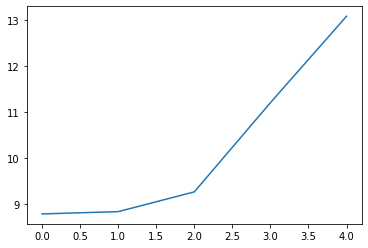

In [9]:
res_l = torch.load(pt_path +'lambda_choice_ours0.pt')
n = res_l.size(1)
_,i = torch.sort(res_l[0,:])
res_l = res_l[:,i]


print("la")
print(res_l[2,:])
print("sigma")
print(res_l[3,:])

print("result")
print(res_l[0,:])
print("ecart type")
print(torch.sqrt(res_l[1,:]))


plt.figure()
plt.plot(list(range(n)),res_l[0,:])
#plt.xlim(30,40)
plt.show()

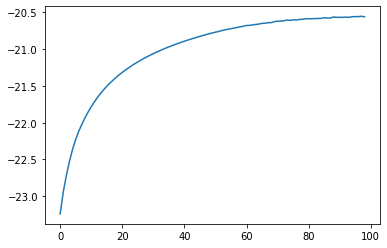

In [119]:
data_set = torch.load(data_path)
#ndata = data_set.size(0)
#data_set = data_set.view(ndata,1)
la = 1e-20
px = makepx(data_set,la,sigma = 0.6,Niter = 100)

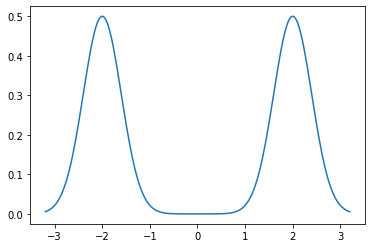

integral = 1.0256442259552565
integral = 0.987115755326442
tensor(0)
tensor(37696102.9727)
integral = 1.0130243021489909


In [120]:
#xtest = torch.linspace(-5,5,3000)
c,rad,ntest = 0,4,1000
xtest2 = gentest(ntest,c,rad)
xtest = torch.zeros((ntest//2,d))
xtest[:,0] = c + rad*(2*torch.rand(ntest//2) - 1)
ytest = px(xtest)
ytest2 = px(xtest2)
print((ytest < 0).sum())
print(ytest.sum()*(2*rad)**d/ntest)
ydata_set = px(data_set)



torch.save(xtest,pt_path+'xtest_ours1.pt')
torch.save(ytest,pt_path+'ytest_ours1.pt')
torch.save(ydata_set,pt_path+'ydata_ours1.pt')
torch.save(xtest2,pt_path+'xtest2_ours1.pt')
torch.save(ytest2,pt_path+'ytest2_ours1.pt')
#torch.save(xtest,pt_path+'xtest_linear0.pt')
#torch.save(ytest,pt_path+'ytest_linear0.pt')
#torch.save(ydata_set,pt_path+'ydata_linear0.pt')



#torch.save(xtest,pt_path+'xtest_linear0.pt')
#torch.save(ytest,pt_path+'ytest_linear0.pt')
#torch.save(ydata_set,pt_path+'ydata_linear0.pt')

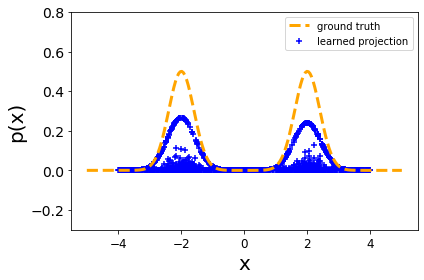

In [153]:
xtest = torch.load(pt_path+'xtest_ours1.pt')
ytest = torch.load(pt_path+'ytest_ours1.pt')
xdata = torch.load(pt_path+'xdataExperiments.pt')
ydata_set = torch.load(pt_path+'ydata_ours1.pt')
xtest2 = torch.load(pt_path+'xtest2_ours1.pt')
ytest2 = torch.load(pt_path+'ytest2_ours1.pt')


xhaha = torch.linspace(-rad,rad,200)
yhaha = 0.5*(torch.exp(-(xhaha-r_data)**2/(2*sigma_data**2)) +torch.exp(-(xhaha+r_data)**2/(2*sigma_data**2)) )




#xtest = torch.load(pt_path+'xtest_linear0.pt')
#ytest = torch.load(pt_path+'ytest_linear0.pt')
#xdata = torch.load(pt_path+'xdataExperiments.pt')
#ydata_set = torch.load(pt_path+'ydata_linear0.pt')


#ytestref = density_fun(xtest)



fig = plt.figure()
plt.scatter(xtest[:,0],ytest[:],lw = 1.5,label='learned projection',zorder = -1,marker = '+',color = 'b')
plt.scatter(xtest2[:,0],ytest2[:],lw = 1.5,zorder = -1,marker = '+',color = 'b')
plt.plot(xhaha,yhaha,lw = 3,linestyle = 'dashed',label = 'ground truth',color = 'orange')
#plt.plot(xtest,ytestref,linestyle = 'dashed',lw = 3,label = 'ground truth')
#plt.scatter(xdata,ydata_set,marker = '+',color = 'r',lw = 2,label = 'training points',zorder = 1)
plt.legend()
plt.xlabel("x",fontsize = 20)
plt.ylabel("p(x)",fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=12)
plt.ylim(-0.3,0.8)
plt.tight_layout()
fig.savefig('oursPlot0density.pdf' , format='pdf', dpi=100)
plt.show()

# Nadaraya Watson

In [122]:
def makepx(data_set,la,sigma =1,Niter = 1000):
    kmodel = utils.kernelModel(sigma,data_set,kernel = 'gaussian',c = 0,base = base,mu_base = mu_base,eta_base = eta_base)
    dm = utils.densityModelNW(kmodel,la,eps = 0.001)
    al = dm.FISTA(Niter)
    def pxx(x):
        return kmodel.px(al,x)
    return pxx

lambda = 1.0,sigma = 0.1
integral = tensor([[1.0000]])
ll = 25.235603597261562
lambda = 1.0,sigma = 0.5
integral = tensor([[1.0000]])
ll = 9.315673462108567
lambda = 1.0,sigma = 1.0
integral = tensor([[1.0000]])
ll = 12.573461554462488
lambda = 1.0,sigma = 5.0
integral = tensor([[1.0000]])
ll = 22.16737029626569
lambda = 0.01,sigma = 0.1
integral = tensor([[1.0000]])
ll = 25.225962732996162
lambda = 0.01,sigma = 0.5
integral = tensor([[1.]])
ll = 9.090036252954338


KeyboardInterrupt: 

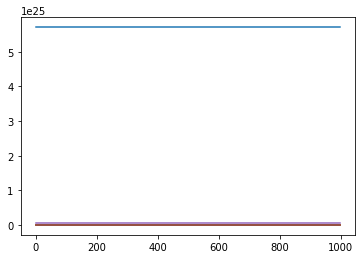

In [19]:
la_list = [1.,1e-2,1e-4,1e-6,1e-8]
sigma_l = [0.1,0.5,1,5]
param_list = []
for la in la_list:
    for sigma in sigma_l:
        param_list.append([la,sigma])
NN = len(param_list)
res = torch.zeros((4,NN))
res[2:,:] = torch.tensor(param_list).T

r = 0.7
K = 1
res_list = []
data_set = torch.load(data_path)
for i in range(NN):
    for k in range(K):
        data_set_train,data_set_test = data_split(data_set,r=r)
        la,sigma = res[2,i],res[3,i]
        px = makepx(data_set_train,la,sigma = sigma)
        print('lambda = {},sigma = {}'.format(la,sigma))
        ll = loglikelihood(px,data_set_test=data_set_test)
        #ll = squareloss(px,data_set_test = data_set_test,ntest = 0,ntestbis = 3000)
        print("ll = {}".format(ll))
        res[0,i] += ll
        res[1,i] += ll**2
    res[0,i]/= K
    res[1,i] /= K
    res[1,i] -= res[0,i]**2




In [ ]:
torch.save(res,pt_path + 'lambda_choice_NW0.pt')

In [38]:
res_l = torch.load(pt_path +'lambda_choice_NW0.pt')
n = res_l.size(1)
_,i = torch.sort(res_l[0,:])
res_l = res_l[:,i]


print("la")
print(res_l[2,:])
print("sigma")
print(res_l[3,:])

print("result")
print(res_l[0,:])
print("ecart type")
print(torch.sqrt(res_l[1,:]))


plt.figure()
plt.plot(list(range(n)),res_l[0,:])
#plt.xlim(30,40)
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'ExperimentsD/tensors/lambda_choice_NW0.pt'

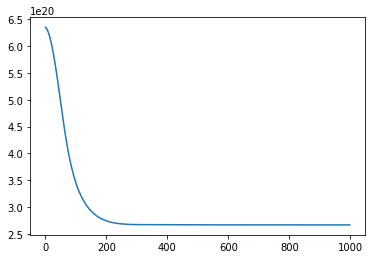

In [136]:
data_set = torch.load(data_path)
#ndata = data_set.size(0)
#data_set = data_set.view(ndata,1)
la = 1
px = makepx(data_set,la,sigma = 0.5,Niter = 1000)

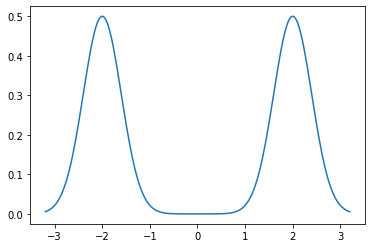

integral = tensor([[1.0000]])
integral = tensor([[1.0000]])
tensor(0)
tensor(280721.4301)
integral = tensor([[1.0000]])


In [137]:
#xtest = torch.linspace(-5,5,3000)
c,rad,ntest = 0,4,1000
xtest2 = gentest(ntest,c,rad)
xtest = torch.zeros((ntest//2,d))
xtest[:,0] = c + rad*(2*torch.rand(ntest//2) - 1)
ytest = px(xtest)
ytest2 = px(xtest2)
print((ytest < 0).sum())
print(ytest.sum()*(2*rad)**d/ntest)
ydata_set = px(data_set)



torch.save(xtest,pt_path+'xtest_NW1.pt')
torch.save(ytest,pt_path+'ytest_NW1.pt')
torch.save(ydata_set,pt_path+'ydata_NW1.pt')
torch.save(xtest2,pt_path+'xtest2_NW1.pt')
torch.save(ytest2,pt_path+'ytest2_NW1.pt')







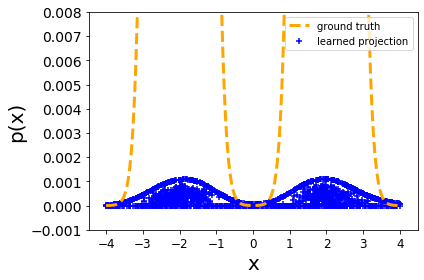

In [162]:
xtest = torch.load(pt_path+'xtest_NW1.pt')
ytest = torch.load(pt_path+'ytest_NW1.pt')
xdata = torch.load(pt_path+'xdataExperiments.pt')
ydata_set = torch.load(pt_path+'ydata_NW1.pt')
xtest2 = torch.load(pt_path+'xtest2_NW1.pt')
ytest2 = torch.load(pt_path+'ytest2_NW1.pt')


xhaha = torch.linspace(-rad,rad,200)
yhaha = 0.5*(torch.exp(-(xhaha-r_data)**2/(2*sigma_data**2)) +torch.exp(-(xhaha+r_data)**2/(2*sigma_data**2)) )




#xtest = torch.load(pt_path+'xtest_linear0.pt')
#ytest = torch.load(pt_path+'ytest_linear0.pt')
#xdata = torch.load(pt_path+'xdataExperiments.pt')
#ydata_set = torch.load(pt_path+'ydata_linear0.pt')


#ytestref = density_fun(xtest)



fig = plt.figure()
plt.scatter(xtest[:,0],ytest[:],lw = 1.5,label='learned projection',zorder = -1,marker = '+',color = 'b')
plt.scatter(xtest2[:,0],ytest2[:],lw = 1.5,zorder = -1,marker = '+',color = 'b')
plt.plot(xhaha,yhaha,lw = 3,linestyle = 'dashed',label = 'ground truth',color = 'orange')
#plt.plot(xtest,ytestref,linestyle = 'dashed',lw = 3,label = 'ground truth')
#plt.scatter(xdata,ydata_set,marker = '+',color = 'r',lw = 2,label = 'training points',zorder = 1)
plt.legend()
plt.xlabel("x",fontsize = 20)
plt.ylabel("p(x)",fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=12)
plt.ylim(-0.001,0.008)
plt.tight_layout()
fig.savefig('NWPlot0density.pdf' , format='pdf', dpi=100)
plt.show()

# GLMS 

In [4]:
def makepx(data_set,la,sigma = 1,Niter = 3000):
    kmodel = utils.kernelExpoModel(sigma,data_set,4,10000,cgrid = None,kernel = 'gaussian',centered = False,c = 10,base = base,mu_base = mu_base,eta_base = eta_base)
    eps = 0.001
    dm = utils.densityModelExpo(kmodel,la,eps=eps)
    al = dm.GD(Niter)
    def pxx(x):
        return kmodel.px(al,x)
    return pxx

In [145]:
def makepx(data_set,la,sigma = 1,Niter = 3000):
    base_sampler,base_density = gen,density_data
    kmodel = utils.kernelExpoModelBis(sigma,data_set,1000,base_sampler,base_density,kernel = 'gaussian',centered = False,c = 0,useGPU = False,nmax_gpu = None)
    eps = 0.001
    dm = utils.densityModelExpo(kmodel,la,eps=eps)
    al = dm.GD(Niter)
    def pxx(x):
        return kmodel.px(al,x)
    return pxx



In [157]:
def makepx(data_set,la,sigma = 1,Niter = 3000):
    ngrid = 1000
    kmodel = utils.kernelExpoModelTer(sigma,data_set,ngrid,kernel = 'gaussian',base = 'gaussian',mu_base = 0,eta_base = 5)
    eps = 0.001
    dm = utils.densityModelExpo(kmodel,la,eps=eps)
    al = dm.GD(Niter)
    def pxx(x):
        return kmodel.px(al,x)
    return pxx

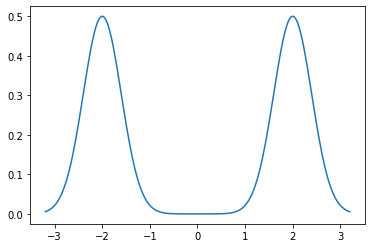

lambda = 0.001,sigma = 0.3
ll = 5.821007885374887


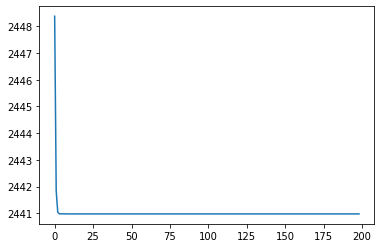

In [146]:
la_list = [1e-3]
sigma_l = [0.3]
param_list = []
for la in la_list:
    for sigma in sigma_l:
        param_list.append([la,sigma])
NN = len(param_list)
res = torch.zeros((4,NN))
res[2:,:] = torch.tensor(param_list).T

r = 0.7
K = 1
res_list = []
data_set = torch.load(data_path)
for i in range(NN):
    for k in range(K):
        data_set_train,data_set_test = data_split(data_set,r=r)
        la,sigma = res[2,i],res[3,i]
        px = makepx(data_set_train,la,sigma = sigma,Niter = 200)
        print('lambda = {},sigma = {}'.format(la,sigma))
        ll = loglikelihood(px,data_set_test=data_set_test)
        #ll = squareloss(px,data_set_test = data_set_test,ntest = 0,ntestbis = 3000)
        print("ll = {}".format(ll))
        res[0,i] += ll
        res[1,i] += ll**2
    res[0,i]/= K
    res[1,i] /= K
    res[1,i] -= res[0,i]**2




In [147]:
torch.save(res,pt_path + 'lambda_choice_GLM0.pt')

In [148]:
res_l = torch.load('lambda_choice_GLM0.pt')


plt.figure()
plt.plot(list(range(res_l.size(0))),res_l)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'lambda_choice_GLM0.pt'

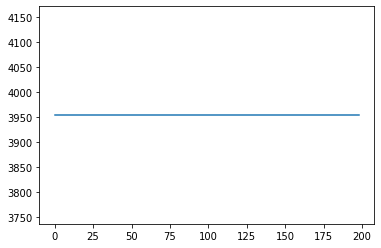

In [158]:
data_set = torch.load(data_path)
#ndata = data_set.size(0)
#data_set = data_set.view(ndata,1)
la = 1e-3
px = makepx(data_set,la,sigma = 0.5,Niter = 200)

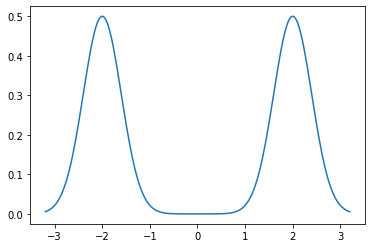

tensor(0)
tensor(0.0051)


In [159]:
#xtest = torch.linspace(-5,5,3000)
c,rad,ntest = 0,4,1000
xtest2 = gentest(ntest,c,rad)
xtest = torch.zeros((ntest//2,d))
xtest[:,0] = c + rad*(2*torch.rand(ntest//2) - 1)
ytest = px(xtest)
ytest2 = px(xtest2)
print((ytest < 0).sum())
print(ytest.sum()*(2*rad)**d/ntest)
ydata_set = px(data_set)



torch.save(xtest,pt_path+'xtest_GLM1.pt')
torch.save(ytest,pt_path+'ytest_GLM1.pt')
torch.save(ydata_set,pt_path+'ydata_GLM1.pt')
torch.save(xtest2,pt_path+'xtest2_GLM1.pt')
torch.save(ytest2,pt_path+'ytest2_GLM1.pt')







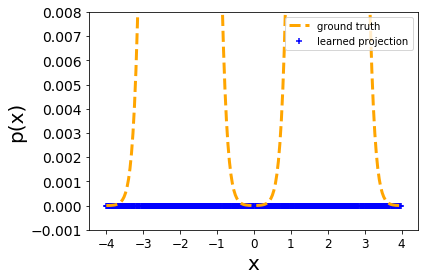

In [161]:
xtest = torch.load(pt_path+'xtest_GLM1.pt')
ytest = torch.load(pt_path+'ytest_GLM1.pt')
xdata = torch.load(pt_path+'xdataExperiments.pt')
ydata_set = torch.load(pt_path+'ydata_GLM1.pt')
xtest2 = torch.load(pt_path+'xtest2_GLM1.pt')
ytest2 = torch.load(pt_path+'ytest2_GLM1.pt')


xhaha = torch.linspace(-rad,rad,200)
yhaha = 0.5*(torch.exp(-(xhaha-r_data)**2/(2*sigma_data**2)) +torch.exp(-(xhaha+r_data)**2/(2*sigma_data**2)) )




#xtest = torch.load(pt_path+'xtest_linear0.pt')
#ytest = torch.load(pt_path+'ytest_linear0.pt')
#xdata = torch.load(pt_path+'xdataExperiments.pt')
#ydata_set = torch.load(pt_path+'ydata_linear0.pt')


#ytestref = density_fun(xtest)



fig = plt.figure()
plt.scatter(xtest[:,0],ytest[:],lw = 1.5,label='learned projection',zorder = -1,marker = '+',color = 'b')
plt.scatter(xtest2[:,0],ytest2[:],lw = 1.5,zorder = -1,marker = '+',color = 'b')
plt.plot(xhaha,yhaha,lw = 3,linestyle = 'dashed',label = 'ground truth',color = 'orange')
#plt.plot(xtest,ytestref,linestyle = 'dashed',lw = 3,label = 'ground truth')
#plt.scatter(xdata,ydata_set,marker = '+',color = 'r',lw = 2,label = 'training points',zorder = 1)
plt.legend()
plt.xlabel("x",fontsize = 20)
plt.ylabel("p(x)",fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=12)
plt.ylim(-0.001,0.008)
plt.tight_layout()
fig.savefig('GLMPlot0density.pdf' , format='pdf', dpi=100)
plt.show()

In [144]:
xtest = torch.load('xtest_GLM0.pt')
ytest = torch.load('ytest_GLM0.pt')
res = 0 
for i in range(len(xtest)-1):
    res += (xtest[i+1]-xtest[i])*ytest[i]
print(res-1)

FileNotFoundError: [Errno 2] No such file or directory: 'xtest_GLM0.pt'

In [38]:
print((a*v).sum(1))

tensor([3.1354, 2.9594])


In [22]:
v.max()

tensor(0.8970)

In [5]:
import scipy.special as scp

In [6]:
scp.gammaln(2)

0.0

In [8]:
c = 1
def f(c):
    if c == 1:
        raise NameError('dd')
    else:
        return 0
f(1)

NameError: dd

In [8]:
import torch
v = torch.rand((2,3))
print(((v*v).sum()).view((1,1)))

tensor([[2.3506]])


In [17]:
c = v.T@v

In [18]:
print(c)

tensor([[0.7140]])


In [20]:
v.expand((2,3))

tensor([[0.1991, 0.1991, 0.1991],
        [0.8212, 0.8212, 0.8212]])

In [ ]:

fig, ax = plt.subplots(dpi=100)
for i, yi in enumerate(y.T):
   ax.plot(x, yi, c=cmap.to_rgba(i + 1))